# Abuse Detection on Social Networking Sites

#### Reddit Domestic Abuse Dataset: https://nicschrading.com/data/

## Data Pre Processing

In [1]:
import pandas as pd
import numpy as np
import re
import itertools
from collections import Counter

In [2]:
import pandas as pd
import shelve

<img src="data/redditAbuseSubmissions.PNG" alt="Drawing" style="width: 400px;"/>

In [3]:
#redditAbuseSubmissions

redditAbuseSubmissions = shelve.open("data/redditAbuseSubmissions")

In [4]:
text = redditAbuseSubmissions["data"]

label = redditAbuseSubmissions["labels"]

subIds = redditAbuseSubmissions["subIds"]

In [5]:
#Creating a dataframe with data

data = {'id':subIds, 'text':text, 'label':label}

data = pd.DataFrame(data)

data.head()

,id,text,label
0,2wjl43,I cant eat pls help I need help\nMy anxiety ha...,non_abuse
1,2tdh8q,"Financial Independence I am 18, with no job an...",abuse
2,2vwei8,Who decided that online calculus assignments w...,non_abuse
3,p013r,My friend recently told me she was abused as a...,abuse
4,2xrdhg,How's it going on this monday night? I am list...,non_abuse


In [6]:
import pandas as pd
pd.options.display.max_columns = 200
pd.options.mode.chained_assignment = None

from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))
stop = list(stop)
from string import punctuation
from functools import reduce

from collections import Counter
import re
import numpy as np

import matplotlib.pyplot as plt

from tqdm import tqdm_notebook
tqdm_notebook().pandas()

%matplotlib inline

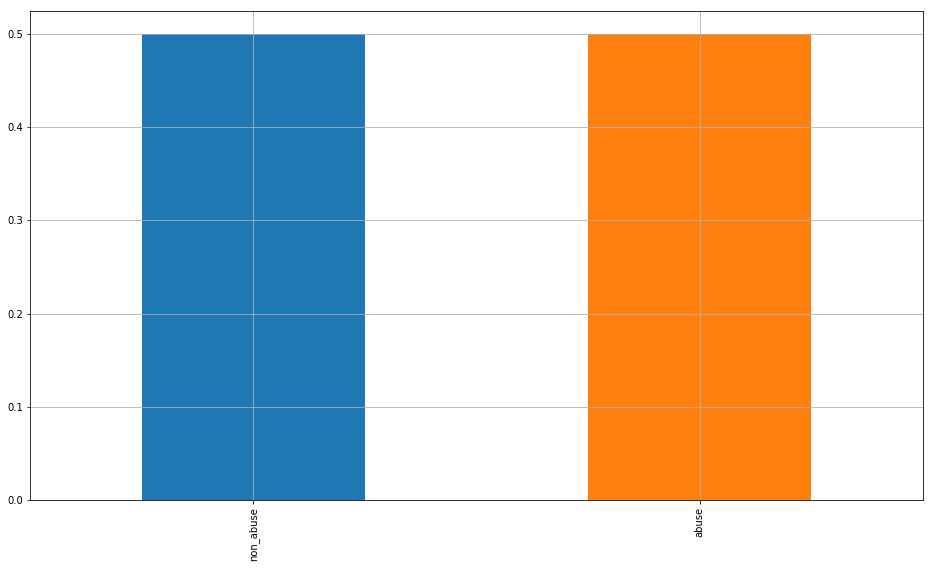

In [7]:
data.label.value_counts(normalize=True).plot(kind='bar', grid=True, figsize=(16, 9))

In [8]:
#Source: https://ahmedbesbes.com/how-to-mine-newsfeed-data-and-extract-interactive-insights-in-python.html

def removeNonAscii(s): 
    return "".join(i for i in s if(ord(i)<128))

def clean_str(string):
    """
    Tokenization/string cleaning for all datasets except for SST.
    Original taken from https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
    """
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    string = re.sub(r"what's", "what is ", string)
    string = string.replace('(ap)', '')
    string = re.sub(r"\'s", " is ", string)
    string = re.sub(r"\'ve", " have ", string)
    string = re.sub(r"can't", "cannot ", string)
    string = re.sub(r"n't", " not ", string)
    string = re.sub(r"i'm", "i am ", string)
    string = re.sub(r"\'re", " are ", string)
    string = re.sub(r"\'d", " would ", string)
    string = re.sub(r"\'ll", " will ", string)
    return string.strip().lower()

In [9]:
def load_data_and_labels():
    """
    Loads MR polarity data from files, splits the data into words and generates labels.
    Returns split sentences and labels.
    """
    # Load data from files
    examples = data['text']
    examples = list(examples)
    examples = [s.strip() for s in examples]
    
    # Split by words
    x_text = examples
    x_text = [clean_str(sent) for sent in x_text]
    x_text = [removeNonAscii(sent) for sent in x_text]
    x_text = [s.split(" ") for s in x_text]
    
    # Generate labels
    y = list(data['label'].map(lambda x : 1 if x=='abuse' else 0))
    
#     print("load data and labels:", [len(x_text),len(y)])
    return [x_text, y]

In [10]:
def build_vocab(sentences):
    """
    Builds a vocabulary mapping from word to index based on the sentences.
    Returns vocabulary mapping and inverse vocabulary mapping.
    """
    # Build vocabulary
    word_counts = Counter(itertools.chain(*sentences))
    # Mapping from index to word
    vocabulary_inv = [x[0] for x in word_counts.most_common()]
    # Mapping from word to index
    vocabulary = {x: i for i, x in enumerate(vocabulary_inv)}
    
#     print("Vocabulary: ", len(vocabulary), len(vocabulary_inv))
    return [vocabulary, vocabulary_inv]

In [11]:
def build_input_data(sentences, labels, vocabulary):
    """
    Maps sentencs and labels to vectors based on a vocabulary.
    """
    x = np.array([[vocabulary[word] for word in sentence] for sentence in sentences])
    y = np.array(labels)
    
#     print("Build input data:", [len(x),len(y)])
    return [x, y]


In [12]:
def pad_sentences(sentences, padding_word="<PAD/>"):
    """
    Pads all sentences to the same length. The length is defined by the longest sentence.
    Returns padded sentences.
    """
    sequence_length = max(len(x) for x in sentences)
    padded_sentences = []
    for i in range(len(sentences)):
        sentence = sentences[i]
        num_padding = sequence_length - len(sentence)
        new_sentence = sentence + [padding_word] * num_padding
        padded_sentences.append(new_sentence)
        
   #  print("Padded sentences: ", len(padded_sentences))
    return padded_sentences

In [13]:
def preprocess_data():
    """
    Loads and preprocessed data for the MR dataset.
    Returns input vectors, labels, vocabulary, and inverse vocabulary.
    """
    # Load and preprocess data
    sentences, labels = load_data_and_labels()
    sentences_padded = pad_sentences(sentences)
    vocabulary, vocabulary_inv = build_vocab(sentences_padded)
    x, y = build_input_data(sentences_padded, labels, vocabulary)
#     print("Preprocess load data:", [len(x),len(y), len(vocabulary), len(vocabulary_inv)])
    return [x, y, vocabulary, vocabulary_inv]

In [14]:
temp = preprocess_data()

## CNN Model

In [15]:
from tensorflow.python.keras.models import Sequential, Model
from tensorflow.python.keras.layers import Dense, Dropout, Flatten, Input, MaxPooling1D, Convolution1D, Embedding
from tensorflow.python.keras.layers.merge import Concatenate
from tensorflow.python.keras.datasets import imdb
from tensorflow.python.keras.preprocessing import sequence
np.random.seed(0)

In [16]:
# Model Hyperparameters
embedding_dim = 50
filter_sizes = (3, 4, 5)
num_filters = 10
dropout_prob = (0.5, 0.8)
hidden_dims = 50

# Training parameters
batch_size = 16
num_epochs = 10

# Prepossessing parameters
sequence_length = 895
max_words = 10374

In [17]:
def load_data():
    x, y, vocabulary, vocabulary_inv_list = preprocess_data()
    vocabulary_inv = {key: value for key, value in enumerate(vocabulary_inv_list)}
    
    # Shuffle data
    shuffle_indices = np.random.permutation(np.arange(len(y)))
    x = x[shuffle_indices]
    y = y[shuffle_indices]
    train_len = int(len(x) * 0.9)
    x_train = x[:train_len]
    y_train = y[:train_len]
    x_test = x[train_len:]
    y_test = y[train_len:]

    return x_train, y_train, x_test, y_test, vocabulary, vocabulary_inv

In [18]:
# Data Preparation
print("Load data...")
x_train, y_train, x_test, y_test, vocabulary, vocabulary_inv = load_data()

# if sequence_length != x_test.shape[1]:
#     print("Adjusting sequence length for actual size")
#     sequence_length = x_test.shape[1]

print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)
print("Vocabulary Size: {:d}".format(len(vocabulary_inv)))

Load data...
x_train shape: (993, 895)
x_test shape: (111, 895)
Vocabulary Size: 10374


In [19]:
input_shape = (sequence_length,)

model_input = Input(shape=input_shape)

In [20]:
z = Embedding(len(vocabulary_inv), embedding_dim, input_length=sequence_length, name="embedding")(model_input)

z = Dropout(dropout_prob[0])(z)

In [21]:
# Convolutional block
conv_blocks = []
for sz in filter_sizes:
    conv = Convolution1D(filters=num_filters,
                         kernel_size=sz,
                         padding="valid",
                         activation="relu",
                         strides=1)(z)
    conv = MaxPooling1D(pool_size=2)(conv)
    conv = Flatten()(conv)
    conv_blocks.append(conv)
    
z = Concatenate()(conv_blocks) if len(conv_blocks) > 1 else conv_blocks[0]
z = Dropout(dropout_prob[1])(z)
z = Dense(hidden_dims, activation="relu")(z)
z = Dropout(dropout_prob[0])(z)
model_output = Dense(1, activation="sigmoid")(z)
model = Model(model_input, model_output)
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [22]:
# model.summary()

In [23]:
# Train the model
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=num_epochs,
          validation_data=(x_test, y_test), verbose=2)

/home/abhishek/Workspace/env/tensorflow/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 993 samples, validate on 111 samples
Epoch 1/10
 - 4s - loss: 0.6984 - acc: 0.5247 - val_loss: 0.6763 - val_acc: 0.5495
Epoch 2/10
 - 3s - loss: 0.6614 - acc: 0.6113 - val_loss: 0.6677 - val_acc: 0.5676
Epoch 3/10
 - 4s - loss: 0.6554 - acc: 0.6153 - val_loss: 0.6831 - val_acc: 0.6306
Epoch 4/10
 - 3s - loss: 0.6206 - acc: 0.6777 - val_loss: 0.6631 - val_acc: 0.6396
Epoch 5/10
 - 3s - loss: 0.5098 - acc: 0.7805 - val_loss: 0.5834 - val_acc: 0.7117
Epoch 6/10
 - 3s - loss: 0.3449 - acc: 0.8620 - val_loss: 0.4655 - val_acc: 0.7658
Epoch 7/10
 - 3s - loss: 0.1784 - acc: 0.9386 - val_loss: 0.4789 - val_acc: 0.8108
Epoch 8/10
 - 3s - loss: 0.1367 - acc: 0.9486 - val_loss: 0.4324 - val_acc: 0.8288
Epoch 9/10
 - 3s - loss: 0.0689 - acc: 0.9829 - val_loss: 0.4160 - val_acc: 0.8198
Epoch 10/10
 - 3s - loss: 0.0508 - acc: 0.9859 - val_loss: 0.4658 - val_acc: 0.8198


In [24]:
# list all data in history
print(history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


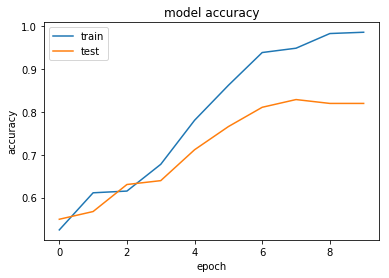

In [25]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

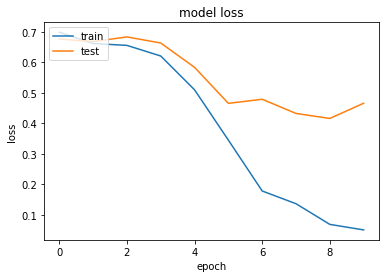

In [26]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [39]:
#test_sentence = "My husband beat me"
test_sentence = "My husband is a great man"

In [40]:
def prepare_new_sentence(sentence):
    
    #Load Vocabulary
    _, _, _, _, vocabulary, vocabulary_inv = load_data()
    
    #Data Pre Processing
    sentence = clean_str(sentence)
    sentence = removeNonAscii(sentence)
    sentence = sentence.strip()
    sentence = sentence.split(" ")
    
    #Padding
    sequence_length = 895
    num_padding = sequence_length - len(sentence)
    sentence = sentence + ["<PAD/>"] * num_padding
    
    #print(sentence)
    
    x_new = np.array([vocabulary[word] for word in sentence])
    
    return x_new

In [41]:
x_new = prepare_new_sentence(test_sentence)

In [42]:
# x_new = x_test[2]

y_new = model.predict(np.array([x_new,]))

print(y_new)

if(np.round(y_new) == 1):
    print("Abuse")

else:
    print("Non-Abuse")

[[0.28025576]]
Non-Abuse
